# Reddit Data Collection

In [1]:
# Importing necessary libraries

import praw
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
import tldextract
import matplotlib.pyplot as plt

### Extracting r/india data using praw

In [2]:
reddit = praw.Reddit(client_id='', client_secret='', user_agent='')
subreddit = reddit.subreddit('india')

*There are a huge number of custom flairs in r/india. In order to decide which ones to consider and which ones to ignore, I am going to consider only the ones which are **officially mentioned** on the r/india page. Hence these **10 flairs** will be used further in this project for all purposes.*

In [3]:
flairs = ['AskIndia', 'Business/Finance', 'Food', 'Non-Political', 'Photography', 'Policy/Economy', 'Politics', 'Scheduled',
          'Science/Technology', 'Sports']

# Function to convert timestamp to datetime
def get_date(created):
    return dt.datetime.fromtimestamp(created)

*For **exploring the distribution of data over flairs**, some posts are extracted first and analysed. This would give an idea about whether randomly extracting the data would be helpful in training a classifier over it.*

In [4]:
topics_dict = {"id":[], "title":[], "flair":[]}

for submission in subreddit.top('year',limit = None):
    topics_dict["id"].append(submission.id)
    topics_dict["title"].append(submission.title)
    topics_dict["flair"].append(submission.link_flair_text)

data = pd.DataFrame(topics_dict)
data = data.loc[data.flair.isin(flairs)]
data.reset_index(drop=True, inplace=True)
data.tail()

,id,title,flair
841,ebim5v,Mumbai protest against government's discrimina...,Politics
842,e1yy9u,"Did Sharad Pawar, NCP, Congress and Shiv Sena ...",Politics
843,cpomk0,"My dad is the Captain onboard Stena Impero, an...",Politics
844,d5gao9,"Modi euphoria gone, foreign investors dump rec...",Politics
845,ecjv68,"Remember this, India, that the people of Hong ...",Politics


### Analyzing the distribution of flair-wise data
*The top posts extracted from the r/india subreddit have a very **unequally distributed** pattern in terms of flair. The bar plot depicts the percentage of posts belonging to our 10 different flairs.*

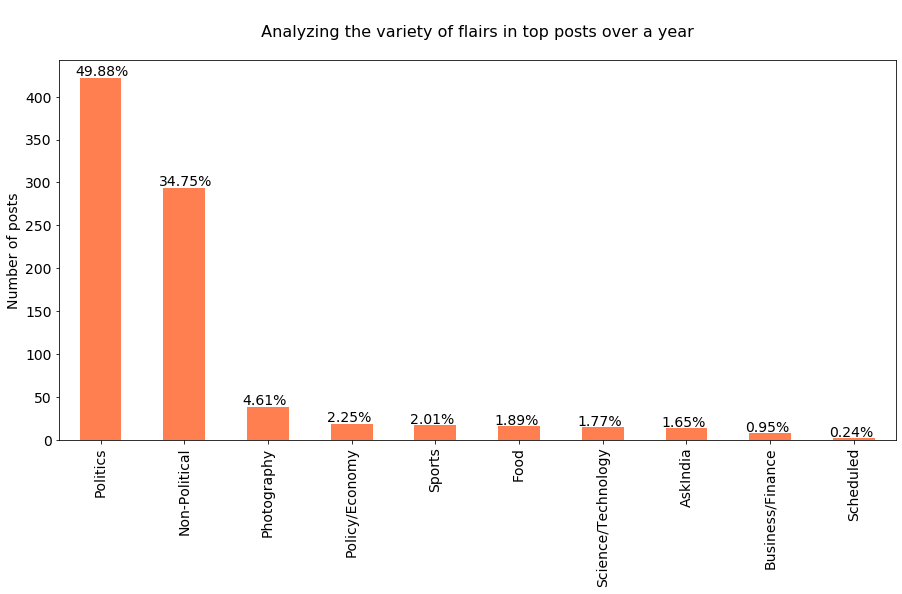

In [6]:
plot = data['flair'].value_counts().plot(kind='bar', figsize=(15,7), color="coral", fontsize=14);
plot.set_title("\n Analyzing the variety of flairs in top posts over a year \n", fontsize=16)
plot.set_ylabel("Number of posts", fontsize=14);

# Find the values and their sum
totals = []
for i in plot.patches:
    totals.append(i.get_height())
total = np.sum(totals)

# Set individual bar lables using above list
for i in plot.patches:
    # get_x pulls left or right; get_height pushes up or down
    plot.text(i.get_x()-0.05, i.get_height()+ 2, str(round((i.get_height()/total)*100, 2))+'%', fontsize=14)

## Extracting relevant submissions
Since the submissions extracted in the above cell shows that distribution with respect to flairs is not uniform, this might create problem when training the classifier model. In order to get even distribution, **around 250** relevant submissions from each flair are extracted to create the required data for traning and analysis purpose. Sorting by 'relevance' is default in the search method, and it collects the posts which are most related to the query.

In [7]:
topics_dict = {"id":[], "flair":[], "title":[], "body":[], "comments":[], "score":[], "author":[], "url":[], "domain":[], "comms_num": [], "created":[]}

# Using tqdm progress bar to track iterations
with tqdm(total=len(flairs)*250) as pbar:
    for flair in flairs:
        get_subreddits = subreddit.search(query = f"flair:{flair}", time_filter='year', limit=300)
        for submission in get_subreddits:    
            topics_dict["flair"].append(submission.link_flair_text)
            topics_dict["title"].append(submission.title)
            topics_dict["score"].append(submission.score)
            topics_dict["id"].append(submission.id)
            topics_dict["url"].append(submission.url)
            topics_dict["comms_num"].append(submission.num_comments)
            topics_dict["created"].append(submission.created)
            topics_dict["body"].append(submission.selftext)
            topics_dict["author"].append(submission.author)
            
            
            # Using top-level-domain extraction methods to find domain of URLs
            tld = tldextract.extract(submission.url)
            d = tld.domain + "." + tld.suffix
            
            # Conditions for some exceptions
            if submission.is_self == True:
                d = "self-post"
            if d == "youtu.be":
                d = "youtube.com"
            if d == "redd.it":
                d = "reddit.com"
                
            topics_dict["domain"].append(d)
    
            submission.comments.replace_more(limit=10)
            comment = ' '
            for top_level_comment in submission.comments:
                comment += ' ' + top_level_comment.body
            topics_dict["comments"].append(comment)
            pbar.update(1)

 97%|█████████████████████████████████████████████████████████████████████████▋  | 2423/2500 [1:04:40<02:03,  1.60s/it]


### Creating a dataframe and saving in csv file

In [8]:
data = pd.DataFrame(topics_dict)

# Converting timestamp to datetime format
_timestamp = data["created"].apply(get_date)
data = data.assign(timestamp = _timestamp)
del data['created']

# Shuffling the rows
data = data.sample(frac=1).reset_index(drop=True)

# Saving the data in csv file
data.to_csv('reddit-india-data.csv', index=False)
data.tail()

,id,flair,title,body,comments,score,author,url,domain,comms_num,timestamp
2418,fvxp4n,Photography,"Lone House at Loktak Lake, Manipur [OC] [6000x...",,"Location - Loktak Lake, Manipur\n\nDevice us...",18,kingof-potatos,https://i.redd.it/trpvocirv6r41.jpg,reddit.com,3,2020-04-07 01:45:54
2419,fcsymx,Sports,When you cross 30 it affects your eyesight: Ka...,,I can imagine googly-eyed Kohli.,23,Ku_hu,https://www.business-standard.com/article/spor...,business-standard.com,1,2020-03-04 00:31:23
2420,dnrkxp,Sports,Copy India's ambition to be the best: Ian Chap...,,Credit should go to kohli for giving utmost ...,22,Shellynoire,https://www.indiatvnews.com/sports/cricket-cop...,indiatvnews.com,5,2019-10-28 00:00:24
2421,enm17q,Sports,India finish 2019 as number one shooting natio...,,> While **India leads the standings with 30 ...,28,Shellynoire,https://www.thehindu.com/sport/other-sports/in...,thehindu.com,17,2020-01-13 00:06:36
2422,e3umqx,Sports,"Leander Paes betters Davis Cup record, India q...",,Leander's a beast. Respect to this great man...,29,xuxebiko,https://www.thehindu.com/sport/tennis/leander-...,thehindu.com,6,2019-12-01 00:24:26
